### Importing the DataSet

In [27]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [28]:
df = pd.read_csv("data/British_Airline_Reviews.csv")

In [29]:
df.head()

,Unnamed: 0,reviews
0,0,✅ Trip Verified | I had an appalling experie...
1,1,"Not Verified | Good points, the cabin crew, t..."
2,2,"Not Verified | It was a decent flight, reason..."
3,3,✅ Trip Verified | I really like flying Briti...
4,4,✅ Trip Verified | Could not book online the ...


### Data Preprocessing
- Lowercasing
- Word Tokenizing
- Removing Punctuation
- Removing Stopwords
- Doing Lemmatization

In [30]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(lemmatizer.lemmatize(i))

    return " ".join(y)

In [31]:
df['transformed_text'] = df['reviews'].apply(transform_text)

In [32]:
df.tail(5)

,Unnamed: 0,reviews,transformed_text
995,995,✅ Trip Verified | I wouldn't even rate them 1...,trip verified would even rate 2 x business cla...
996,996,✅ Trip Verified | Flying London City to Geneva...,trip verified flying london city geneva plus e...
997,997,✅ Trip Verified | Los Angeles to Istanbul via...,trip verified los angeles istanbul via london ...
998,998,✅ Trip Verified | Phoenix to Tel Aviv via Lond...,trip verified phoenix tel aviv via london retu...
999,999,Not Verified | London to Kefalonia . The T5 G...,verified london kefalonia t5 gallery lounge sh...


### Data Analyzing

#### Showing Majority Words in Texts

In [37]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height = 500, min_font_size=6, background_color="white", max_words=100)

In [38]:
majority_words = wc.generate(df['transformed_text'].str.cat(sep = " "))

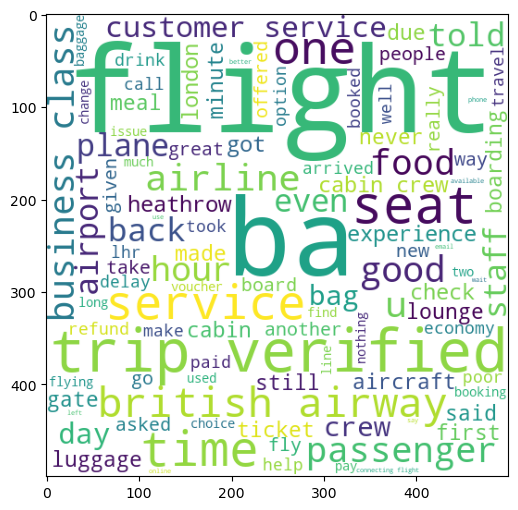

In [85]:
plt.figure(figsize=(15,6))
plt.imshow(majority_words)
plt.savefig("wordcloud.png", bbox_inches='tight')
plt.show()

#### Checking Sentiment Analysis

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [42]:
sid.polarity_scores(df['transformed_text'][1])

{'neg': 0.049, 'neu': 0.799, 'pos': 0.152, 'compound': 0.9413}

In [44]:
df['sentiment_score'] = df['transformed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [45]:
df.head()

,Unnamed: 0,reviews,transformed_text,sentiment_score
0,0,✅ Trip Verified | I had an appalling experie...,trip verified appalling experience british air...,-0.9807
1,1,"Not Verified | Good points, the cabin crew, t...",verified good point cabin crew helpful profess...,0.9413
2,2,"Not Verified | It was a decent flight, reason...",verified decent flight reasonable comfortable ...,0.9081
3,3,✅ Trip Verified | I really like flying Briti...,trip verified really like flying british airwa...,0.9701
4,4,✅ Trip Verified | Could not book online the ...,trip verified could book online night system a...,-0.4767


In [49]:
def get_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment)


In [50]:
df.head()

,Unnamed: 0,reviews,transformed_text,sentiment_score,sentiment_label
0,0,✅ Trip Verified | I had an appalling experie...,trip verified appalling experience british air...,-0.9807,Negative
1,1,"Not Verified | Good points, the cabin crew, t...",verified good point cabin crew helpful profess...,0.9413,Positive
2,2,"Not Verified | It was a decent flight, reason...",verified decent flight reasonable comfortable ...,0.9081,Positive
3,3,✅ Trip Verified | I really like flying Briti...,trip verified really like flying british airwa...,0.9701,Positive
4,4,✅ Trip Verified | Could not book online the ...,trip verified could book online night system a...,-0.4767,Negative


C:\Users\haris\AppData\Local\Temp\ipykernel_13068\3302882320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='Set2')


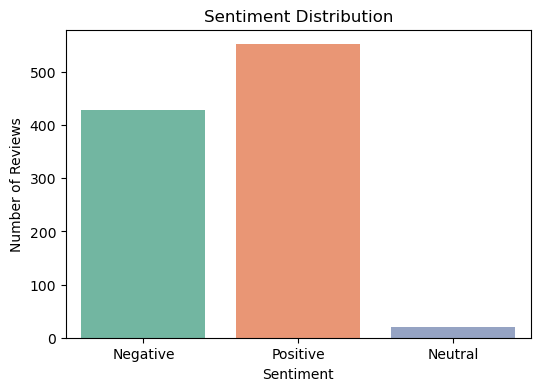

In [84]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.savefig("sentiment_bar.png", bbox_inches='tight')
plt.show()


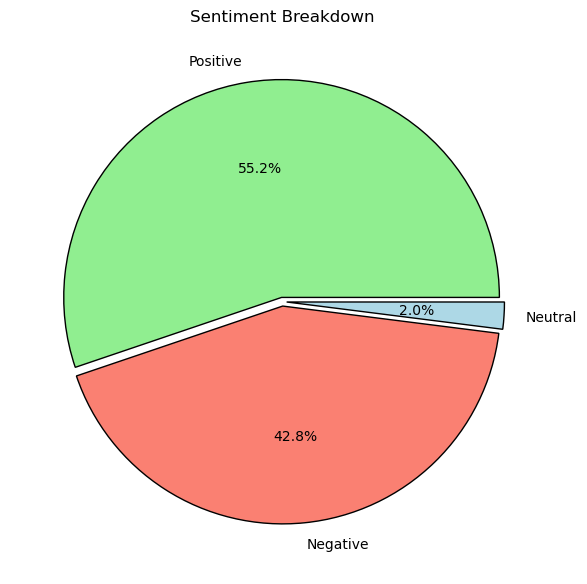

In [83]:
sentiment_counts = df['sentiment_label'].value_counts()
colors = ['lightgreen', 'salmon', 'lightblue']

explode = [0.02] * len(sentiment_counts)

plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    # startangle=140,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)
plt.title('Sentiment Breakdown')
plt.savefig("sentiment_pie.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

### Topic Modeling

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [73]:
# Convert the cleaned reviews to a bag-of-words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['transformed_text'])

In [74]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [78]:
# Get the words used
words = vectorizer.get_feature_names_out()

# Print top 10 words per topic
for i, topic in enumerate(lda.components_):
    print(f"Topic #{i + 1}:")
    print([words[j] for j in topic.argsort()[-10:]])
    print()

Topic #1:
['ba', 'london', 'minute', 'crew', 'paris', 'staff', 'time', 'trip', 'flight', 'plane']

Topic #2:
['passenger', 'food', 'time', 'cabin', 'service', 'trip', 'good', 'crew', 'ba', 'flight']

Topic #3:
['button', 'escalator', 'crew', 'journey', 'helped', 'seat', 'event', 'parent', 'british', 'airway']

Topic #4:
['airline', 'economy', 'service', 'food', 'trip', 'business', 'class', 'ba', 'flight', 'seat']

Topic #5:
['airline', 'day', 'airway', 'british', 'service', 'customer', 'trip', 'hour', 'ba', 'flight']

